In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as spc
from mpl_toolkits.mplot3d import Axes3D

In [29]:
def get_active_cells(traces):

    # going to return a dictionary with only active cells, formatted exactly the same as traces

    d = dict.fromkeys(traces.keys())

    for cell in traces:
        if traces[cell]['active'] == True:
            d[cell] = traces[cell]
        else:
            d.pop(cell,None)

    return d

In [30]:
 # load the first dictionary file
cell = "C:/Users/Conor/Documents/Imaging_Data/Two-Photon/Psilocybin_Project/Evoked_Cohort_Mice/ID269/ID269_19042023_psilocybin/TSeries-04192023-1137-073/suite2p/plane0/cells.pkl"

with open(cell,'rb') as f:
    cell_dict_1 = pickle.load(f)

In [31]:
# Get recording info, number of freqencies, intensities and trials for each combination.
active = get_active_cells(cell_dict_1)
nfreq = list(active[3]['traces'].keys())
nInt = list(active[3]['traces'][nfreq[0]].keys())
ntrial = list(active[3]['traces'][nfreq[0]][nInt[0]].keys())
print(nfreq, nInt, ntrial)

[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922] [35, 50, 65, 80] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [32]:
# Extract the trials for every combination into a matrix of shape nfreq x nInt x nTrials x nCells x nFrames

matrix_all = np.array([[[[active[n]['traces'][i][j][k] for n in active.keys()] for k in ntrial] for j in nInt] for i in nfreq])
print(matrix_all.shape)

(12, 4, 10, 173, 15)


In [33]:
matrix_av = matrix_all.mean(axis=2)
print(matrix_av.shape)
matrix_res = matrix_av[:,:,:,5:].mean(axis=-1) - matrix_av[:,:,:,:5].mean(axis=-1)
print(matrix_res.shape)


(12, 4, 173, 15)
(12, 4, 173)


In [34]:
# Reshape the matrix so that all of the response combinations are flattened, with one dimension for each cell. nFrames (flat) x nCells
matrix_flatten = (matrix_res).reshape(-1,len(matrix_res[0,0,:]))
print(matrix_flatten.shape)

(48, 173)


In [35]:
scaler = StandardScaler()
matrix_flatten = scaler.fit_transform(matrix_flatten)

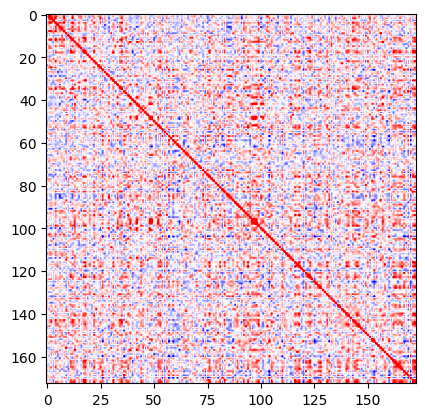

In [36]:
# Compute the pairwise correlations for every cell 
cc = 1-pairwise_distances(matrix_flatten.T, metric='correlation')
plt.imshow(cc, vmin=-.5, vmax=.5, cmap='bwr')

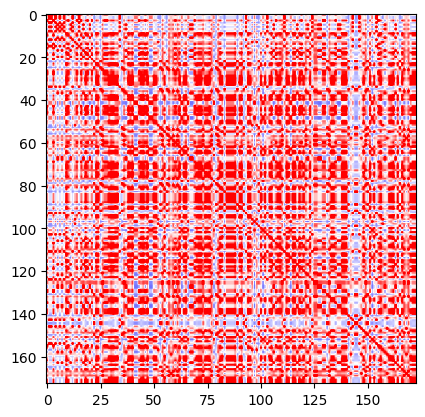

In [37]:
# Run hierarchical clustering on the correlation matrix. 
pdist = spc.distance.pdist(cc)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')
plt.imshow(cc[idx][:,idx], vmin=-0.5, vmax=0.5, cmap='bwr')

(173, 173)
[-0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35
  0.45  0.55  0.65  0.75  0.85  0.95]


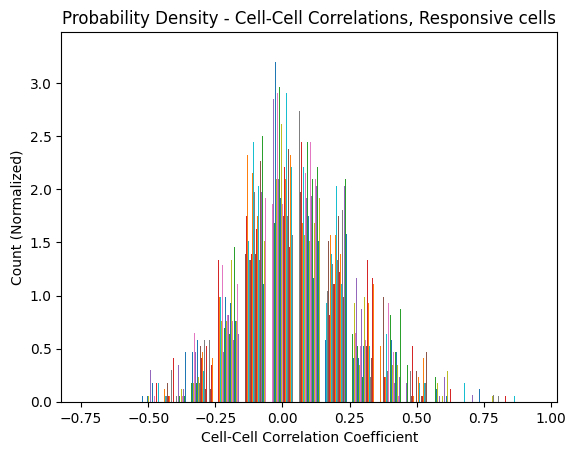

In [38]:
print(cc.shape)
bins = np.arange(-0.75,1,0.1)
plt.hist(cc,bins=bins,density=True)
plt.xlabel("Cell-Cell Correlation Coefficient")
plt.ylabel("Count (Normalized)")
plt.title("Probability Density - Cell-Cell Correlations, Responsive cells")

print(bins)